In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) 
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('C:/Users/JIEUN OH/OneDrive/바탕 화면/Kaggle_data/Titanic/train.csv')
df_test = pd.read_csv('C:/Users/JIEUN OH/OneDrive/바탕 화면/Kaggle_data/Titanic/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## 3. Feature engineering
---
- 가장 먼저 dataset에 존재하는 null data를 채우려고 한다.
- 아무 숫자로 채울 수는 없고, null data를 포함하는 feature의 statistics를 참고하거나 다른 아이디어를 짜내어 채울 수 있다.
- null data를 어떻게 채우느냐에 따라 모델 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분이다. 
- **Feature engineering은 실제 모델의 학습에 쓰려고 하는 것이므로 train뿐만 아니라 test도 똑같이 적용해주어야한다.**

### 3.1 Fill Null
---
#### 3.1.1 Fill Null in Age using title
---
- Age에는 null data가 177개나 있다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics를 사용해 보겠다.  

- 영어에서는 Miss, Mr, Mrs 같은 title이 존재한다. 각 탑승객의 이름에는 곡 이런 title이 들어가게 되는데 이를 사용해보겠다.  

- pandas series에는 data를 string으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있다. 이를 사용하여 title을 쉽게 추출할 수 있다. title을 initial column에 저장하겠다.

In [2]:
# title 추출해서 initial column에 저장
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

- 판다스에서 문자열 관련 함수를 사용하거나 전처리 하기 위해서는 str 메소드를 사용해야한다.           
그 중 원하는 문자열을 추출하기 위해선 extract 함수가 필요하다.

- pandas의 crosstab을 이용하여 우리가 추출한 Initial과 Sex간의 count를 살펴보자.

In [3]:
pd.crosstab(df_train.Initial, df_train.Sex).T.style.background_gradient(cmap='summer_r') 
#Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table을 참고하여 남성, 여성이 쓰는 initial을 구분해보겠다. replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환해준다.

In [5]:
df_train.Initial.replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test.Initial.replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [14]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


-> 여성과 관계있는 Miss, Mrs가 생존률이 높은 것을 볼 수 있다.

<AxesSubplot:xlabel='Initial'>

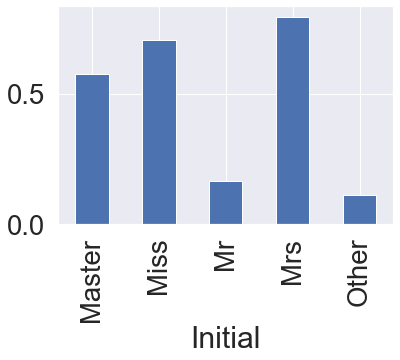

In [6]:
df_train.groupby('Initial').Survived.mean().plot.bar()

- 이제 본격적으로 Null을 채울 것이다. null data를 채우는 방법은 정말 많이 존재한다. statistics를 활용하느 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있다. 여기서는 statistics를 활용하는 방법을 사용할 것이다.        


- 여기서 statistics는 train data의 것을 의미한다. 우리는 언제나 test를 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 한다.

In [16]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value를 채우도록 하겠다.
- pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 참으로 편리하다
- 아래 코드 첫줄을 해석하자면 isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 Age의 값을 33으로 치환하다는 것이다.
- loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해지자.

In [7]:
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Other'), 'Age'] = 46

-> 여기선 간단하게 null을 채웠지만 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재한다.
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보면서 공부해보기.

#### 3.1.2 Fill Null in Embarked
---

In [18]:
print('Embarked has ', sum(df_train.Embarked.isnull()), ' Null values')

Embarked has  2  Null values


-> Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠다.
- dataframe의 fillna method를 이용하면 쉽게 채울 수 있다. 여기서 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 된다.

In [8]:
df_train.Embarked.fillna('S', inplace=True)

### 3.2 Change Age(continuous to categorical)
---
- Age는 현재 continuous feature이다. 이대로 써도 모델을 세울 수 있지만, Age를 몇개의 group 으로 나누어 category화 시켜줄 수도 있다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있지만 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠다.

- 방법은 여러가지가 있다. dataframe의 indexing 방법인 loc를 사용하여 직접해줄 수 있고, 아니면 apply를 사용해 함수를 넣어줄 수 있다.
- 첫번째로 loc를 사용한 방법이다. loc는 자주 쓰게 되므로 그 사용법을 숙지하면 좋겠다.
- 나이는 10살 간격으로 나누겠다.

In [9]:
df_train['Age_cat'] = 0
df_train.loc[df_train.Age < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train.Age) & (df_train.Age < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train.Age) & (df_train.Age < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train.Age) & (df_train.Age < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train.Age) & (df_train.Age < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train.Age) & (df_train.Age < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train.Age) & (df_train.Age < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train.Age, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test.Age < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train.Age) & (df_train.Age < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train.Age) & (df_train.Age < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train.Age) & (df_train.Age < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train.Age) & (df_train.Age < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train.Age) & (df_train.Age < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train.Age) & (df_train.Age < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train.Age, 'Age_cat'] = 7

- 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법이다.
- 훨씬 수월하다.

In [10]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] = df_train.Age.apply(category_age)

- 두가지 방법이 잘 적용됐다면, 둘다 같은 결과를 내야한다.
- 이를 확인하기 위해 Series간 boolean 비교 후 all() 메소드를 사용한다. 
 > - all(): 모든 값이 True면 True, 하나라도 False가 있으면 False를 준다.

In [13]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train.Age_cat == df_train.Age_cat_2).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


-> True이니 둘 중 편한걸 선택하면 된다.   

- 중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하겠다.

In [14]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

### 3.3 Change Initial, Embarked and Sex(string to numerical)
---
- 현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야한다.
- **map method를 가지고 간단히 할 수 있다.**
- 사전 순서대로 정리하여 mapping 하겠다.

In [15]:
df_train.Initial = df_train.Initial.map({'Mster':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test.Initial = df_test.Initial.map({'Mster':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

- Embarked도 C, Q, S로 이루어져 있다. map을 이용해서 바꿔보겠다.
- 그러기 앞서서, 특정 column에 어떤 값들이 있는지 확인해보는 방법을 잠깐 살펴보겠다. 간단히 unique() 메소들 쓰거나, value_counts() 를 써서 count까지 보는 방법이 있다.

In [16]:
df_train.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [17]:
df_train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- 위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수도 있다. 이제 map을 사용해보겠다.

In [19]:
df_train.Embarked = df_train.Embarked.map({'C':0, 'Q':1, 'S':2})
df_test.Embarked = df_test.Embarked.map({'C':0, 'Q':1, 'S':2})

- 한번 Null이 사라졌는지 확인해보자. Embarked Column만 가져온 것은 하나의 pandas의 series 객체이므로, isnull() 메소드를 사용해 series 값들이 null인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any를 사용해서 True가 단 하나라도 있을시(null이 한개라도 있을 시) True를 반환해주게 된다. 우리는 Null을 S로 다 바꿔주었으므로 False를 얻게 된다.

In [20]:
df_train.Embarked.isnull().any()

False

- Sex도 Female, Male로 이뤄져 있다. map을 이용해 바꿔보자.

In [21]:
df_train.Sex = df_train.Sex.map({'female':0, 'male':1})
df_test.Sex = df_test.Sex.map({'female':0, 'male':1})

- 이제 각 feature 간의 상관관계를 한번 보려고 한다. 두 변수간의 pearson correlation을 구하면 (-1,1) 사이의 값을 얻을 수 있다. 

- 우리는 여러 feature를 가지고 있으니 하나의 matrix 형태로 보면 편할 텐데, 이를 heatmap plot이라고 하며, dataframe의 corr()의 메소드와 seaborn을 가지고 편하게 그릴 수 있다.

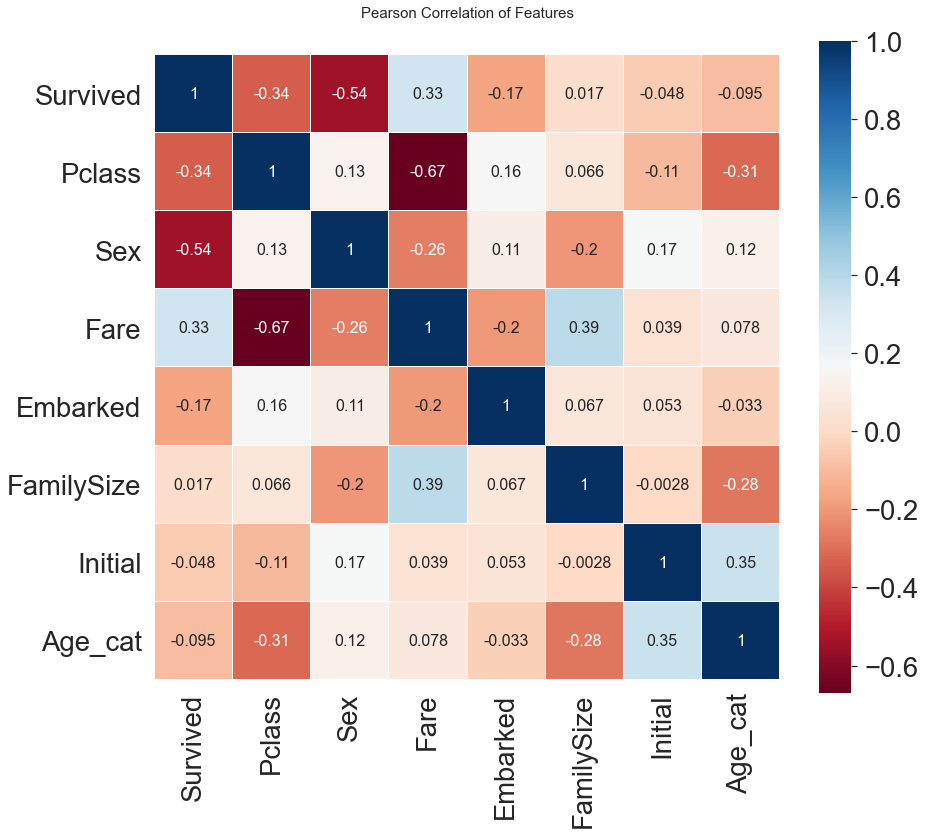

In [23]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':16})

del heatmap_data

-> 우리가 EDA에서도 살펴봤듯이 Sex와 Pclass가 Survived에 상관관계가 어느 정도 있음을 볼 수 있다.    
-> 생각보다 fare와 Embarked도 상관관계가 있음을 볼 수 있다.     
-> 서로 강한 상관관계를 가지는 feature들이 없다.              
=> 이것은 우리가 모델을 학습시킬 때, 불필요한(redundantk superflous)  feature가 없다는 것을 의미한다.   
- 이제 실제로 모델을 학습시키기 앞서 data preprocessing을 진행해보겠다.



### 3.4 One-hot encoding on Initial and Embarked
---
- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4로 매핑해주는 것을 말한다. 
- One-hot encoding은 위 카테고리를 (0, 1)로 이루어진 5차원의 벡터로 나타내는 것을 말한다. 
- 이 작업을 pandas의 get_dummies 를 사용하여 쉽게 해결할 수 있다. 
- 총 5개의 카테고리니, one-hot encoding을 하고 나면 새로운 5개의 column이 생겨난다. 
- Initial을 prefix로 두어서 구분이 쉽게 만들어준다.

In [24]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [25]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,1,0,0


- Embarked에도 적용하겠다. Initial때와 마찬가지로 one-hot encoding을 사용해 표현하겠다.

In [26]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- sklearn으로 Labelencoder + OneHotencoder 이용해도 one-hot encoding이 가능하다.
- 다른 튜토리얼에서도 한번 써보겠다. 여기서는 get_dummies로 충분히 가능하기 때문에 get_dummies 만으로 끝내겠다.
- 가끔 category가 100개가 넘어가는 경우가 있다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 때가 있다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠다.

### 3.5 Drop columns
---
- 필요한 columns만 남기고 다 지우겠다.

In [28]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [29]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,1,0,0,0,0,1


In [30]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,0,0,0,1,0,0,0,1


-> train의 Survived feature(target class)를 빼면 train, test 둘 다 같은 columns를 가진걸 확인할 수 있다.

## 4. Building machine learning model and prediction using the trained model
- 이제 준비가 다 되었으니 sklearn을 사용해 본격적으로 머신러닝 모델을 만들어보자.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

- 지금 타이타닉 문제는 target cass(survived)가 있으며, target class는 0, 1로 이루어져 있으므로 binary classification 문제이다.
- 우리가 지금 가지고 있는 train set의 survived를 제외한 input을 가지고 모델을 최적화시켜 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어낸다.
- 그 후 모델이 학습하지 않았던 test set을 input으로 주어서 test set의 각 샘플(탑승객)의 생존 유무를 예측해본다.

### 4.1 Preparation - Split dataset into train, valid, test set
---
- 가장 먼저 학습에 쓰일 데이터와 target label(survived)를 분리한다. drop을 사용해 간단히 할 수 있다.

In [33]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train.Survived.values
X_test = df_test.values

- 보통 train, test만 언급되지만 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해본다.
- train_test_split을 사용하여 쉽게 train셋을 분리할 수 있다.

In [34]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠다.
- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델이다. 
- 각 머신러닝 알고리즘에는 여러 파라미터들이 있다. 랜덤포레스트 분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파리미터들이 존재한다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라진다.
- 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두고, 기본 default 세팅으로 진행하겠다.
- 모델 객체를 만들고, fit 메소드로 학습시킨다.
- 그런 후 valid set input을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻는다.

### 4.2 Model generation and prediction
---

In [35]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

- 모델의 성능을 살펴보기

In [37]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.46% 정확도로 생존을 맞춤


-> 아무런 파라미터 튜닝도 하지 않았는데 82%의 정확도가 나왔다.

### 4.3 Feature importance
---
- 학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있다.
- 학습된 모델은 기본적으로 feature importances를 가지고 있어서 쉽게 그 수치를 얻을 수 있다.
- pandas series를 이용하면 쉽게 sorting을 하여 그래프를 그릴 수 있다.

In [38]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

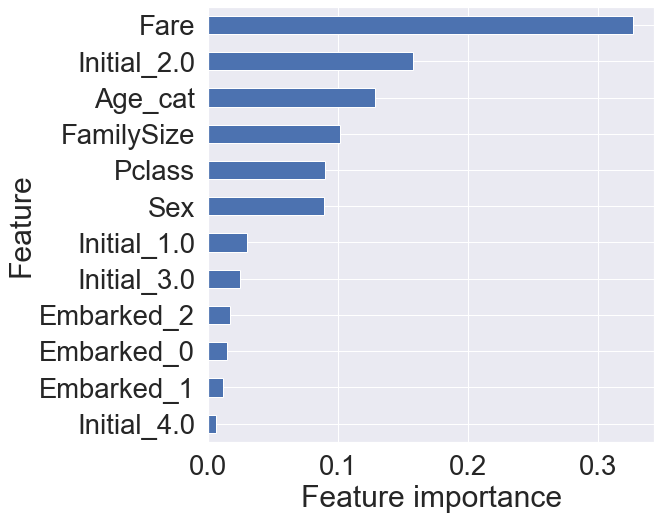

In [40]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

-> 우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며 그 뒤로 Initial_2, Age_cat, Pclass가 차례대로 중요도를 가진다.
- 만약 다른 모델을 사용하게 되면 feature importance가 다르게 나올 수 있다.               

-> 이 feature importance 를 보고 실제로 Fare 가 중요한 feature일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야한다.
- feature importance를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 좀 더 빠른 모델을 위해 feature를 제거할 수도 있다.

### 4.4 Prediction on Test set
- 이제 모델이 학습하지 않았던 테스트셋을 모델에 주어서 생존여부를 예측해보겠다.
- 이 결과는 실제로 submission 이므로 결과는 leaderboard에서 확인할 수 있다.

In [ ]:
submission = pd.read_csv('../input/gender_submission.csv')
submission.head()

- 이제 테스트셋에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠다.

In [ ]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [ ]:
submission.to_csv('./my_first_submission.csv', index=False)